# Movie Recommender System

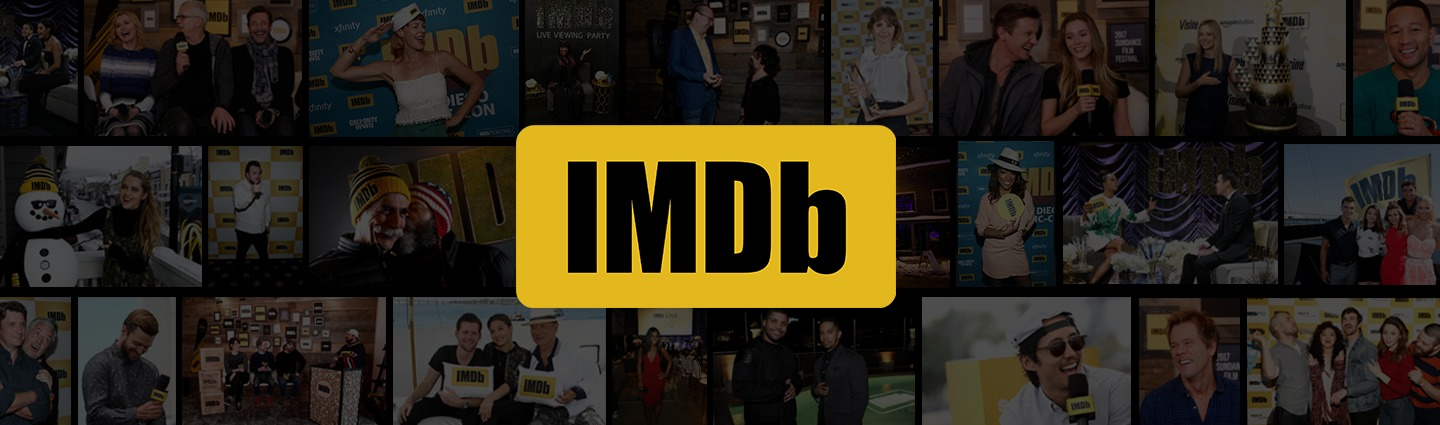

In [1]:
!pip install scikit-surprise

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering, NormalPredictor
from surprise.model_selection import cross_validate

import warnings
warnings.simplefilter('ignore')

In [3]:
md = pd.read_csv('/Users/JumpMan/Downloads/Kaggle DataSets /Movie Recommender/movies_metadata.csv')
md.head()

adult                              belongs_to_collection    budget  \
0  FALSE  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  FALSE                                                NaN  65000000   
2  FALSE  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  FALSE                                                NaN  16000000   
4  FALSE  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497                en   
2                                   NaN  15602  tt0113228                en   
3                                   NaN  31357  tt0114885                en   
4                                   NaN  11862  tt0113041                en   

                original_title  \
0                    Toy Story   
1                      Jumanji   
2             Grumpier Old Men   
3            Waiting to Exhale   
4  Father of the Bride Part II   

                                            overview  ... release_date  \
0  Led by Woody, Andy's toys live happily in his ...  ...     10/30/95   
1  When siblings Judy and Peter discover an encha...  ...     12/15/95   
2  A family wedding reignites the ancient feud be...  ...     12/22/95   
3  Cheated on, mistreated and stepped on, the wom...  ...     12/22/95   
4  Just when George Banks has recovered from his ...  ...      2/10/95   

       revenue runtime                                   spoken_languages  \
0  373554033.0    81.0           [{'iso_639_1': 'en', 'name': 'English'}]   
1  262797249.0   104.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
2          0.0   101.0           [{'iso_639_1': 'en', 'name': 'English'}]   
3   81452156.0   127.0           [{'iso_639_1': 'en', 'name': 'English'}]   
4   76578911.0   106.0           [{'iso_639_1': 'en', 'name': 'English'}]   

     status                                            tagline  \
0  Released                                                NaN   
1  Released          Roll the dice and unleash the excitement!   
2  Released  Still Yelling. Still Fighting. Still Ready for...   
3  Released  Friends are the people who let you be yourself...   
4  Released  Just When His World Is Back To Normal... He's ...   

                         title  video vote_average vote_count  
0                    Toy Story  False          7.7     5415.0  
1                      Jumanji  False          6.9     2413.0  
2             Grumpier Old Men  False          6.5       92.0  
3            Waiting to Exhale  False          6.1       34.0  
4  Father of the Bride Part II  False          5.7      173.0  

[5 rows x 24 columns]

In [4]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x : [i['name']
                                                                              for i in x]
                                                                  if isinstance(x, list)else [])


## IMDB's Weighted Formula
# IMDb Weighted Rating Calculation

IMDb uses a weighted average scheme rather than a simple arithmetic mean to calculate ratings. The exact current formula is not publicly disclosed, but IMDb originally used the following formula:

\[ W = \frac{(R \cdot v) + (C \cdot m)}{v + m} \]

Where:
- **W** is the weighted rating.
- **R** is the mean rating for the movie (on a scale from 1 to 10).
- **v** is the number of votes for the movie.
- **m** is the minimum number of votes required to be listed in the Top 250 (25,000 as of 2013).
- **C** is the mean vote across the whole report (7.0 as of 2013).

This formula is equivalent to a Bayesian posterior mean. The weighting system aims to balance the movie's individual rating with an "a priori" overall average rating. It gives more weight to movies with more votes, while movies with few votes are pulled more towards the overall average.

IMDb states they use filters to detect and mitigate ballot stuffing and vote manipulation. The full details of the current weighting methodology are kept confidential to prevent gaming of the system. There is often a discrepancy between the displayed weighted rating and the arithmetic mean of all votes.

For the Top 250 list, only ratings from "regular voters" are used, but the criteria for this are not disclosed.


In [5]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511


The value __5.244896612406511__ represents the mean vote (average rating) across the whole report in your movie dataset. Here’s what it means in the context of IMDb's weighted rating formula:

In [6]:
m = vote_counts.quantile(0.95)
m

434.0

The value of m is __434.0__ means that only the top 5% of movies in terms of vote count will be considered for the weighted rating. In other words, a movie must have at least 434 votes to be included in the calculation for the Top 250 list or similar rankings based on weighted ratings.

In [7]:
# Extracting the year from the release date and handling missing values
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)


In [8]:
# Filtering movies based on vote count, vote average, and ensuring they are not null
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
# Converting vote counts and vote averages to integers
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')


In [9]:
# Displaying the shape of the resulting DataFrame
qualified.shape
# This helps to quickly check how many movies meet the criteria and are included in the qualified DataFrame.

(2274, 6)

Therefore, to qualify to be considered for the chart, a movie has to have at least __434 votes__ on TMDB. We also see that the average rating for a movie on TMDB is __5.244__ on a scale of 10. __2274__ Movies qualify to be on our chart.

In [10]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

W=( 
v+m
v
​
 ×R)+( 
m+v
m
​
 ×C)

Where:

𝑊
W is the weighted rating.
𝑣
v is the number of votes for the movie.

𝑚
m is the minimum votes required.

𝑅
R is the mean rating of the movie.

𝐶
C is the mean vote across the whole dataset.

__The purpose of this weighted rating is to ensure that movies with a small number of votes do not disproportionately influence the ranking by being either very high or very low in the ratings. This helps to provide a more stable and fair ranking system by balancing individual movie ratings with a baseline average rating.__








In [11]:
#The weighted_rating function is applied to each movie in the qualified DataFrame, calculating the weighted rating (wr) for each movie
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [12]:
#The top 250 movies are selected based on their weighted ratings, resulting in a DataFrame that contains 
#the top 250 movies as per the weighted rating formula.
qualified = qualified.sort_values('wr', ascending=False).head(250)


## Top Movies

In [13]:
qualified.head(20)

title  year  vote_count  \
15480                                          Inception  2010       14075   
12481                                    The Dark Knight  2008       12269   
22879                                       Interstellar  2014       11187   
2843                                          Fight Club  1999        9678   
4863   The Lord of the Rings: The Fellowship of the Ring  2001        8892   
292                                         Pulp Fiction  1994        8670   
314                             The Shawshank Redemption  1994        8358   
7000       The Lord of the Rings: The Return of the King  2003        8226   
351                                         Forrest Gump  1994        8147   
5814               The Lord of the Rings: The Two Towers  2002        7641   
256                                            Star Wars  1977        6778   
1225                                  Back to the Future  1985        6239   
834                                        The Godfather  2072        6024   
1154                             The Empire Strikes Back  1980        5998   
46                                                 Se7en  1995        5915   
24860                                 The Imitation Game  2014        5895   
359                                        The Lion King  1994        5520   
18465                                   The Intouchables  2011        5410   
22841                           The Grand Budapest Hotel  2014        4644   
586                             The Silence of the Lambs  1991        4549   

       vote_average  popularity  \
15480             8   29.108149   
12481             8  123.167259   
22879             8   32.213481   
2843              8   63.869599   
4863              8   32.070725   
292               8  140.950236   
314               8   51.645403   
7000              8   29.324358   
351               8   48.307194   
5814              8   29.423537   
256               8   42.149697   
1225              8   25.778509   
834               8   41.109264   
1154              8   19.470959   
46                8    18.45743   
24860             8    31.59594   
359               8   21.605761   
18465             8   16.086919   
22841             8   14.442048   
586               8    4.307222   

                                                  genres        wr  
15480  [Action, Thriller, Science Fiction, Mystery, A...  7.917588  
12481                   [Drama, Action, Crime, Thriller]  7.905871  
22879                [Adventure, Drama, Science Fiction]  7.897107  
2843                                             [Drama]  7.881753  
4863                        [Adventure, Fantasy, Action]  7.871787  
292                                    [Thriller, Crime]  7.868660  
314                                       [Drama, Crime]  7.864000  
7000                        [Adventure, Fantasy, Action]  7.861927  
351                             [Comedy, Drama, Romance]  7.860656  
5814                        [Adventure, Fantasy, Action]  7.851924  
256                 [Adventure, Action, Science Fiction]  7.834205  
1225        [Adventure, Comedy, Science Fiction, Family]  7.820813  
834                                       [Drama, Crime]  7.814847  
1154                [Adventure, Action, Science Fiction]  7.814099  
46                            [Crime, Mystery, Thriller]  7.811669  
24860                    [History, Drama, Thriller, War]  7.811074  
359                           [Family, Animation, Drama]  7.799175  
18465                                    [Drama, Comedy]  7.795394  
22841                                    [Comedy, Drama]  7.764530  
586                             [Crime, Drama, Thriller]  7.760041

## Genre Filtration

In [14]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)


In [15]:
def build_chart(genre, percentile=0.85):
    # Filter the dataset to include only movies of the specified genre
    df = gen_md[gen_md['genre'] == genre]
    
    # Extract vote counts and vote averages, converting them to integer type
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    
    # Calculate the mean vote average (C) across all movies in the genre
    C = vote_averages.mean()
    
    # Determine the minimum vote count (m) required for a movie to be considered,
    # based on the specified percentile
    m = vote_counts.quantile(percentile)
    
    # Filter the dataset to include only movies with a vote count greater than or equal to m,
    # and with non-null vote counts and vote averages
    qualified = df[(df['vote_count'] >= m) & 
                   (df['vote_count'].notnull()) & 
                   (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    
    # Convert vote counts and vote averages to integer type
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    # Calculate the weighted rating (wr) for each movie using the IMDb weighted rating formula
    qualified['wr'] = qualified.apply(
        lambda x: (x['vote_count'] / (x['vote_count'] + m) * x['vote_average']) + 
                  (m / (m + x['vote_count']) * C), 
        axis=1)
    
    # Sort the movies by their weighted rating in descending order and select the top 250 movies
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified


__Genres__

In [16]:
# Extract genres and create a set of unique genre types
all_genres = set()
for genres in md['genres']:
    for genre in genres:
        all_genres.add(genre)

# Display the unique genre types
all_genres


{'Action',
 'Adventure',
 'Animation',
 'Aniplex',
 'BROSTA TV',
 'Carousel Productions',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'GoHands',
 'History',
 'Horror',
 'Mardock Scramble Production Committee',
 'Music',
 'Mystery',
 'Odyssey Media',
 'Pulser Productions',
 'Rogue State',
 'Romance',
 'Science Fiction',
 'Sentai Filmworks',
 'TV Movie',
 'Telescene Film Group Productions',
 'The Cartel',
 'Thriller',
 'Vision View Entertainment',
 'War',
 'Western'}

__Top Romance Movies__


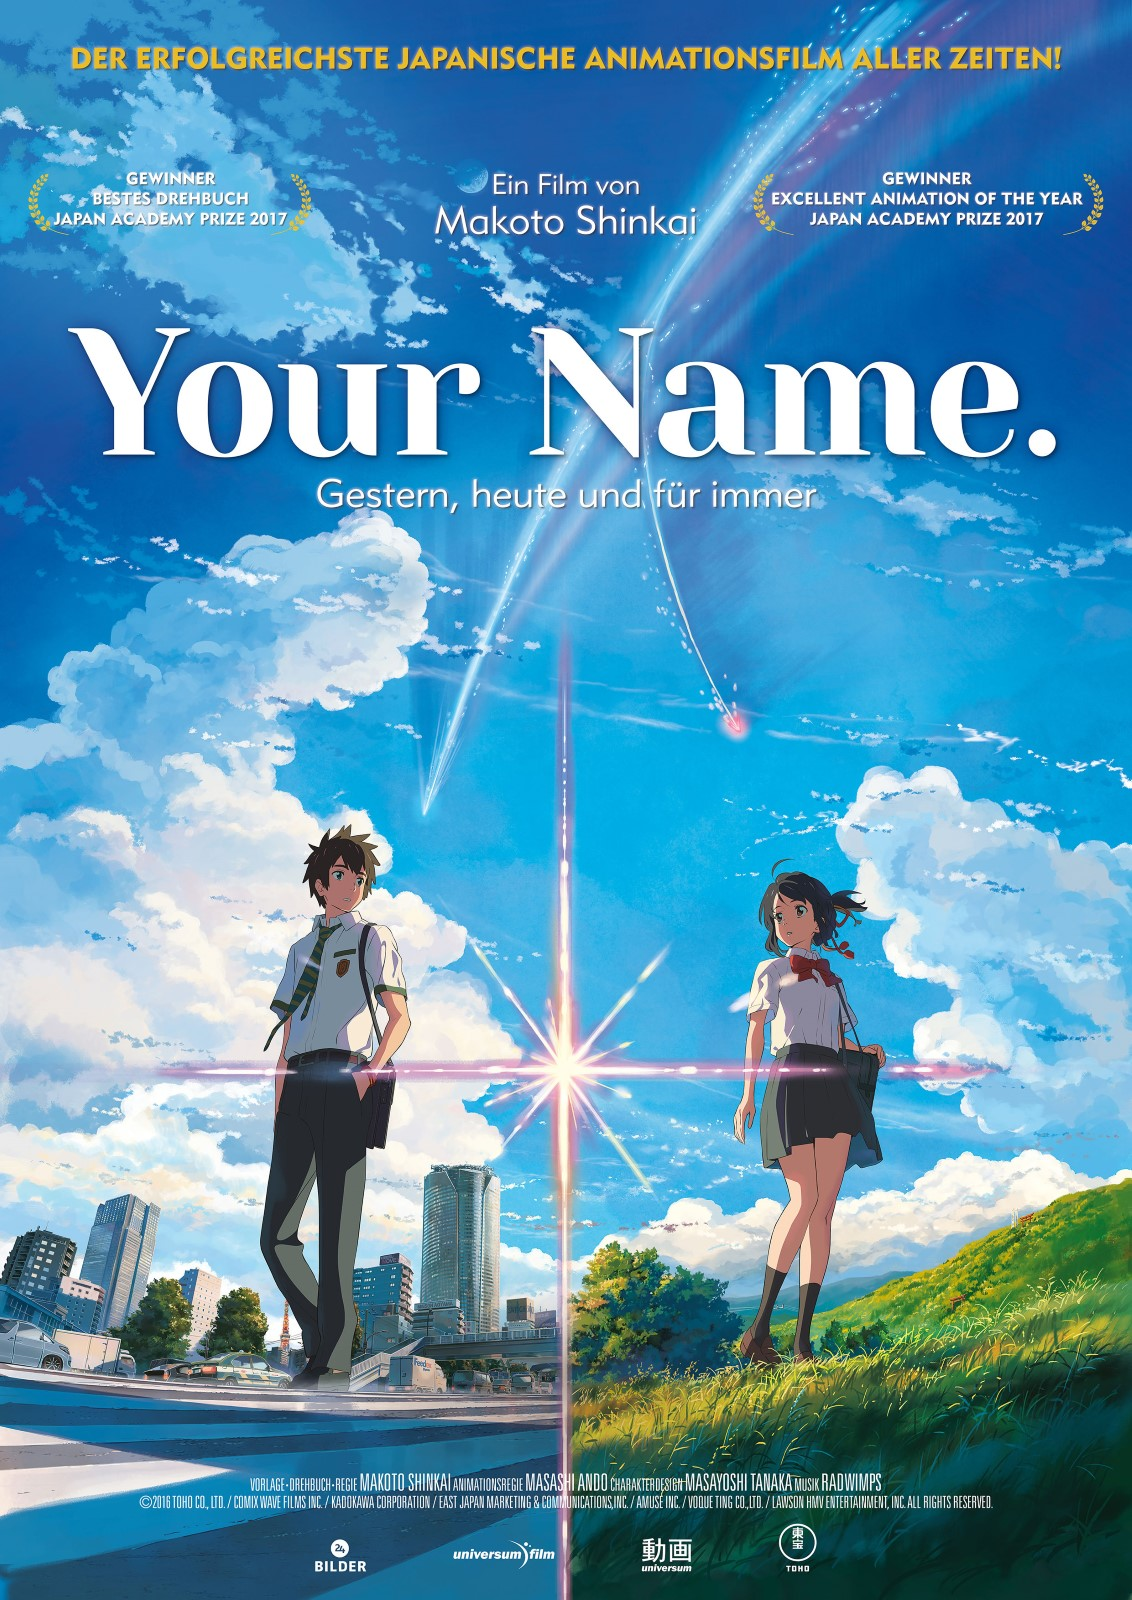

In [17]:
build_chart('Romance').head(15)


title  year  vote_count  vote_average popularity  \
10309  Dilwale Dulhania Le Jayenge  1995         661             9  34.457024   
351                   Forrest Gump  1994        8147             8  48.307194   
876                        Vertigo  2058        1162             8   18.20822   
40251                   Your Name.  2016        1030             8  34.461252   
883               Some Like It Hot  2059         835             8  11.845107   
1132               Cinema Paradiso  1988         834             8  14.177005   
19901                     Paperman  2012         734             8   7.198633   
37863                  Sing Street  2016         669             8  10.672862   
882                  The Apartment  2060         498             8  11.994281   
38718               The Handmaiden  2016         453             8  16.727405   
3189                   City Lights  2031         444             8  10.891524   
24886             The Way He Looks  2014         262             8   5.711274   
45437               In a Heartbeat  2017         146             8   20.82178   
1639                       Titanic  1997        7770             7   26.88907   
19731      Silver Linings Playbook  2012        4840             7  14.488111   

             wr  
10309  8.565285  
351    7.971357  
876    7.811667  
40251  7.789489  
883    7.745154  
1132   7.744878  
19901  7.713951  
37863  7.689483  
882    7.599317  
38718  7.566166  
3189   7.558867  
24886  7.331363  
45437  7.003959  
1639   6.981546  
19731  6.970581

__Top Action Movies__


In [18]:
build_chart('Action').head(15)


title  year  vote_count  \
15480                                          Inception  2010       14075   
12481                                    The Dark Knight  2008       12269   
4863   The Lord of the Rings: The Fellowship of the Ring  2001        8892   
7000       The Lord of the Rings: The Return of the King  2003        8226   
5814               The Lord of the Rings: The Two Towers  2002        7641   
256                                            Star Wars  1977        6778   
1154                             The Empire Strikes Back  1980        5998   
4135                                            Scarface  1983        3017   
9430                                              Oldboy  2003        2000   
1910                                       Seven Samurai  2054         892   
43190                                   Band of Brothers  2001         725   
1215                                                   M  2031         465   
14551                                             Avatar  2009       12114   
17818                                       The Avengers  2012       12000   
26564                                           Deadpool  2016       11444   

       vote_average  popularity        wr  
15480             8   29.108149  7.955099  
12481             8  123.167259  7.948610  
4863              8   32.070725  7.929579  
7000              8   29.324358  7.924031  
5814              8   29.423537  7.918382  
256               8   42.149697  7.908327  
1154              8   19.470959  7.896841  
4135              8   11.299673  7.802046  
9430              8   10.616859  7.711649  
1910              8    15.01777  7.426145  
43190             8    7.903731  7.325485  
1215              8   12.752421  7.072073  
14551             7  185.070892  6.966363  
17818             7   89.887648  6.966049  
26564             7  187.860492  6.964431

__Top Animation Movies__


In [19]:
build_chart('Animation').head(15)


title  year  vote_count  vote_average  \
359                      The Lion King  1994        5520             8   
5481                     Spirited Away  2001        3968             8   
9698              Howl's Moving Castle  2004        2049             8   
2884                 Princess Mononoke  1997        2041             8   
5833                My Neighbor Totoro  1988        1730             8   
40251                       Your Name.  2016        1030             8   
5553            Grave of the Fireflies  1988         974             8   
19901                         Paperman  2012         734             8   
39386                            Piper  2016         487             8   
20779                    Wolf Children  2012         483             8   
25044                  Song of the Sea  2014         420             8   
31658                            Feast  2014         420             8   
19101                           Presto  2008         371             8   
24209  The Tale of the Princess Kaguya  2013         350             8   
13724                               Up  2009        7048             7   

      popularity        wr  
359    21.605761  7.909339  
5481   41.048867  7.875933  
9698   16.136048  7.772103  
2884   17.166725  7.771305  
5833   13.507299  7.735274  
40251  34.461252  7.589820  
5553    0.010902  7.570962  
19901   7.198633  7.465676  
39386  11.243161  7.285132  
20779  10.249498  7.281198  
25044   6.967358  7.212999  
31658   7.365663  7.212999  
19101   8.563861  7.150295  
24209   7.566053  7.120255  
13724  19.330884  6.961798

__Top Comedy Movies__


In [20]:
build_chart('Comedy').head(15)


title  year  vote_count  \
10309                        Dilwale Dulhania Le Jayenge  1995         661   
351                                         Forrest Gump  1994        8147   
1225                                  Back to the Future  1985        6239   
18465                                   The Intouchables  2011        5410   
22841                           The Grand Budapest Hotel  2014        4644   
2211                                   Life Is Beautiful  1997        3643   
732    Dr. Strangelove or: How I Learned to Stop Worr...  2064        1472   
3342                                        Modern Times  2036         881   
883                                     Some Like It Hot  2059         835   
1236                                  The Great Dictator  2040         756   
882                                        The Apartment  2060         498   
3189                                         City Lights  2031         444   
31658                                              Feast  2014         420   
3192                                             The Kid  2021         404   
2906                                         The General  2026         240   

       vote_average popularity        wr  
10309             9  34.457024  8.463024  
351               8  48.307194  7.963363  
1225              8  25.778509  7.952358  
18465             8  16.086919  7.945207  
22841             8  14.442048  7.936384  
2211              8   39.39497  7.919430  
732               8    9.80398  7.809073  
3342              8   8.159556  7.695554  
883               8  11.845107  7.680781  
1236              8   9.241748  7.651762  
882               8  11.994281  7.504715  
3189              8  10.891524  7.456698  
31658             8   7.365663  7.432234  
3192              8   8.168456  7.414663  
2906              8   8.002953  7.142722

__Top Documentary Movies__

In [21]:
build_chart('Documentary').head(15)


title  year  vote_count  \
43320                                   Planet Earth II  2016          50   
16881                                             Senna  2010         282   
21556                         One Direction: This Is Us  2013         209   
39085                                      Planet Earth  2006         176   
23325                                 Jodorowsky's Dune  2013         172   
19392                                           Samsara  2011         169   
3555                                             Baraka  1992         156   
12027                                  The King of Kong  2007         148   
13252  Dear Zachary: A Letter to a Son About His Father  2008         146   
25802                             The Salt of the Earth  2014         146   
40885                                              13th  2016         133   
6285                            Man with a Movie Camera  2029         114   
33420                                             Human  2015          98   
8502                                      Night and Fog  2055          97   
41702                               I Am Not Your Negro  2017          87   

       vote_average popularity        wr  
43320             9   5.651997  8.063355  
16881             8  11.331859  7.847945  
21556             8   5.988929  7.799122  
39085             8   4.501137  7.765013  
23325             8    6.18442  7.760075  
19392             8   9.491177  7.756233  
3555              8   9.925348  7.738058  
12027             8   5.376821  7.725460  
13252             8   5.531686  7.722120  
25802             8   5.154091  7.722120  
40885             8   8.255986  7.698251  
6285              8   4.694378  7.654933  
33420             8   3.845853  7.607480  
8502              8  11.144661  7.604078  
41702             8  11.781919  7.566496

__Top Fantasy Movies__

In [22]:
build_chart('Fantasy').head(15)


title  year  vote_count  \
4863   The Lord of the Rings: The Fellowship of the Ring  2001        8892   
7000       The Lord of the Rings: The Return of the King  2003        8226   
5814               The Lord of the Rings: The Two Towers  2002        7641   
3030                                      The Green Mile  1999        4166   
5481                                       Spirited Away  2001        3968   
9698                                Howl's Moving Castle  2004        2049   
2884                                   Princess Mononoke  1997        2041   
5833                                  My Neighbor Totoro  1988        1730   
926                                It's a Wonderful Life  2046        1103   
14551                                             Avatar  2009       12114   
19971                  The Hobbit: An Unexpected Journey  2012        8427   
26555                       Star Wars: The Force Awakens  2015        7993   
6390   Pirates of the Caribbean: The Curse of the Bla...  2003        7191   
4766            Harry Potter and the Philosopher's Stone  2001        7188   
2576                                  The Legend of 1900  1998         554   

       vote_average  popularity        wr  
4863              8   32.070725  7.888126  
7000              8   29.324358  7.879484  
5814              8   29.423537  7.870711  
3030              8    19.96678  7.772216  
5481              8   41.048867  7.761880  
9698              8   16.136048  7.574941  
2884              8   17.166725  7.573545  
5833              8   13.507299  7.511144  
926               8   15.031588  7.306584  
14551             7  185.070892  6.948550  
19971             7   23.253089  6.927048  
26555             7   31.626013  6.923273  
6390              7   47.326665  6.915162  
4766              7   38.187238  6.915128  
2576              8    7.668214  6.905609

In [23]:
build_chart('Crime').head(15)


title  year  vote_count  vote_average  popularity  \
12481           The Dark Knight  2008       12269             8  123.167259   
292                Pulp Fiction  1994        8670             8  140.950236   
314    The Shawshank Redemption  1994        8358             8   51.645403   
834               The Godfather  2072        6024             8   41.109264   
46                        Se7en  1995        5915             8    18.45743   
586    The Silence of the Lambs  1991        4549             8    4.307222   
289      Leon: The Professional  1994        4293             8   20.477329   
3030             The Green Mile  1999        4166             8    19.96678   
1057             Reservoir Dogs  1992        3821             8    12.22034   
1178     The Godfather: Part II  1974        3418             8   36.629307   
49           The Usual Suspects  1995        3334             8   16.302466   
1170                 GoodFellas  1990        3211             8   15.424092   
4135                   Scarface  1983        3017             8   11.299673   
109                 Taxi Driver  1976        2632             8   14.092713   
5878                City of God  2002        1852             8    14.95927   

             wr  
12481  7.957677  
292    7.940522  
314    7.938355  
834    7.915273  
46     7.913765  
586    7.889007  
289    7.882696  
3030   7.879291  
1057   7.868957  
1178   7.854398  
49     7.850946  
1170   7.845585  
4135   7.836299  
109    7.814116  
5878   7.743770

# Content Based Filtering
The two content based recommenders will be based on 

    Movie Overviews and Taglines
    Movie Cast, Crew, Keywords and Genre

In [24]:
links = pd.read_csv('/Users/JumpMan/Downloads/Kaggle DataSets /Movie Recommender/links_small.csv')
links = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')


In [25]:
md = md.drop([19730, 29503, 35587])

In [26]:
#Check EDA Notebook for how and why I got these indices.
md['id'] = md['id'].astype('int')

In [27]:
smd = md[md['id'].isin(links)]
smd.shape

(9099, 25)

__Movie Description Based Recommender__
This will try to recommend similar movies based on their taglines and descriptions as opposed to any quantitative metrics.

In [28]:
# Fill NaN values in the 'tagline' column with empty strings
smd['tagline'] = smd['tagline'].fillna('')

# Combine 'overview' and 'tagline' columns to create a new 'description' column
# If 'overview' or 'tagline' is NaN, it will be replaced with an empty string
smd['description'] = smd['overview'] + smd['tagline']

# Fill NaN values in the new 'description' column with empty strings
smd['description'] = smd['description'].fillna('')


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer with specific parameters
tf = TfidfVectorizer(
    analyzer='word',      # Tokenize the text at word level
    ngram_range=(1, 2),   # Consider both unigrams (single words) and bigrams (two consecutive words)
    min_df=1,             # Only include terms that appear in at least one document
    stop_words='english'  # Remove common English stop words (e.g., 'the', 'a', 'an')
)

# Fit the vectorizer to the data and transform the text into a TF-IDF matrix
tfidf_matrix = tf.fit_transform(smd['description'])

In [30]:
tfidf_matrix.shape


(9099, 268123)

Cosine Similarity¶
I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

cosine(x,y)=x.y⊺||x||.||y||
 
Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [31]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


__linear_kernel() function:__

Function from scikit-learn's metrics.pairwise module.
Computes the linear kernel between sets of vectors.
In this case, equivalent to computing the cosine similarity.

__Cosine similarity:__

Measure of similarity between two non-zero vectors in an inner product space.
linear_kernel() called with tfidf_matrix as both first and second arguments.
Computes similarity of each document (movie description) with every other document, including itself.

__Computation process:__

For each pair of rows (i, j) in the tfidf_matrix, calculates the dot product of the vectors.
TF-IDF vectors are normalized, so dot product is equivalent to cosine of angle between vectors.

__Output cosine_sim:__

Result is a square symmetrical matrix where:
Each row and column represents a movie.
Value at position (i, j) represents cosine similarity between movie i and movie j.
Diagonal of matrix will all be 1's (each document perfectly similar to itself).

__Interpretation:__

Cosine similarity values range from -1 to 1.
1 indicates perfect similarity (identical direction in vector space).
0 indicates no similarity (orthogonal vectors).
-1 indicates perfect dissimilarity (opposite directions), which is rare with non-negative TF-IDF values.

__Use in recommendation systems:__

Similarity matrix often used in content-based recommendation systems.
Allows quick lookup of most similar items to a given item based on TF-IDF representations.

In [32]:
cosine_sim[0]


array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

The next step is to write a function that returns the 30 most similar movies based on the cosine similarity score.

In [33]:
# Reset the index of the DataFrame smd
# This is useful if the DataFrame has been filtered or modified, and we want to ensure a clean, sequential index
smd = smd.reset_index()

# Extract the 'title' column from the DataFrame smd
# This creates a Series containing the titles of the movies
titles = smd['title']

# Create a Pandas Series where the index is the movie title and the value is the corresponding index of the DataFrame smd
# This allows for easy lookup of movie indices by their titles
indices = pd.Series(smd.index, index=smd['title'])

In [34]:
def get_recommendations(title):
    # Check if the title exists in the indices
    if title not in indices:
        print(f"Title '{title}' not found in the dataset.")
        return None
    
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 30 most similar movies
    sim_scores = sim_scores[1:31]
    
    # Get the movie indices and scores
    movie_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]
    
    # Return the top 30 most similar movies with their scores
    result_df = pd.DataFrame({
        'title': titles.iloc[movie_indices].values,
        'cosine_similarity': scores
    })
    
    return result_df

__Recomendation Time__

In [35]:
# Assuming 'md' is your DataFrame containing the movie metadata

# Print all original titles
for title in md['original_title']:
    print(title)

Toy Story
Jumanji
Grumpier Old Men
Waiting to Exhale
Father of the Bride Part II
Heat
Sabrina
Tom and Huck
Sudden Death
GoldenEye
The American President
Dracula: Dead and Loving It
Balto
Nixon
Cutthroat Island
Casino
Sense and Sensibility
Four Rooms
Ace Ventura: When Nature Calls
Money Train
Get Shorty
Copycat
Assassins
Powder
Leaving Las Vegas
Othello
Now and Then
Persuasion
La Cité des Enfants Perdus
摇啊摇，摇到外婆桥
Dangerous Minds
Twelve Monkeys
Guillaumet, les ailes du courage
Babe
Carrington
Dead Man Walking
Across the Sea of Time
It Takes Two
Clueless
Cry, the Beloved Country
Richard III
Dead Presidents
Restoration
Mortal Kombat
To Die For
How To Make An American Quilt
Se7en
Pocahontas
When Night Is Falling
The Usual Suspects
Guardian Angel
Mighty Aphrodite
Lamerica
The Big Green
Georgia
Kids of the Round Table
Home for the Holidays
Il postino
Le confessionnal
The Indian in the Cupboard
Eye for an Eye
Mr. Holland's Opus
Don't Be a Menace to South Central While Drinking Your Juice in th

In [36]:
get_recommendations("The Godfather").head(10)

title  cosine_similarity
0   The Godfather: Part II           0.220060
1               The Family           0.100294
2                     Made           0.067618
3       Johnny Dangerously           0.065622
4           Shanghai Triad           0.056142
5                     Fury           0.056028
6           American Movie           0.055023
7  The Godfather: Part III           0.050235
8                  8 Women           0.047508
9            Summer of Sam           0.045952

In [37]:
# Function to safely get and display recommendations
def display_recommendations(title):
    recommendations = get_recommendations(title)
    if recommendations is not None:
        print(f"Top 10 recommendations for '{title}':")
        print(recommendations.head(10))
    else:
        print(f"Unable to get recommendations for '{title}'.")

In [38]:
display_recommendations("Toy Story")


Top 10 recommendations for 'Toy Story':
                    title  cosine_similarity
0             Toy Story 2           0.248068
1             Toy Story 3           0.230813
2  The 40 Year Old Virgin           0.127272
3         Man on the Moon           0.101640
4            Factory Girl           0.080479
5  What's Up, Tiger Lily?           0.072698
6   Rebel Without a Cause           0.071859
7  For Your Consideration           0.059213
8        Rivers and Tides           0.056647
9               Condorman           0.055650


In [39]:
display_recommendations("Bad Boys II")

Top 10 recommendations for 'Bad Boys II':
                                      title  cosine_similarity
0                                  Bad Boys           0.099919
1                           Cocaine Cowboys           0.075741
2                                  Scarface           0.070712
3                 Cocaine Cowboys: Reloaded           0.068125
4                              White Chicks           0.059864
5                          Miami Connection           0.059327
6                           American Flyers           0.056872
7                               Miami Blues           0.053451
8  Police Academy 5: Assignment Miami Beach           0.050281
9                          Band of the Hand           0.050225


In [40]:
display_recommendations("Your Name.")

Title 'Your Name.' not found in the dataset.
Unable to get recommendations for 'Your Name.'.


## Metadata Based Recommender

In [41]:
credits = pd.read_csv('/Users/JumpMan/Downloads/Kaggle DataSets /Movie Recommender/credits.csv')
keywords = pd.read_csv('/Users/JumpMan/Downloads/Kaggle DataSets /Movie Recommender/keywords.csv')

In [42]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [43]:
md.shape

(45463, 25)

In [44]:
md = md.merge(credits, on = 'id')
md = md.merge(keywords, on = 'id')

In [45]:
smd = md[md['id'].isin(links)]
smd.shape

(9219, 28)

We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

__Crew:__ From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.

__Cast:__ Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.

In [46]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [47]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [48]:
smd['director'] = smd['crew'].apply(get_director)


In [49]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [50]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [51]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [52]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

__Keywords__

In [53]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [54]:
s = s.value_counts()
s[:5]


keyword
independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: count, dtype: int64

In [55]:
s = s[s > 1]


In [56]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [57]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [58]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [59]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [60]:
count = CountVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [61]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [62]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [63]:
get_recommendations('The Dark Knight').head(10)


title  cosine_similarity
0       The Dark Knight Rises           0.492757
1               Batman Begins           0.468576
2                The Prestige           0.343754
3                   Following           0.295840
4                   Inception           0.271385
5                    Insomnia           0.265789
6                     Memento           0.248069
7                Interstellar           0.204219
8  Batman: Under the Red Hood           0.203390
9              Batman Returns           0.187412

In [64]:
get_recommendations('Mean Girls').head(10)


title  cosine_similarity
0             Head Over Heels           0.462250
1               Freaky Friday           0.388650
2            The House of Yes           0.384615
3            Just Like Heaven           0.384615
4       Mr. Popper's Penguins           0.375117
5  Ghosts of Girlfriends Past           0.368549
6   The Spiderwick Chronicles           0.310316
7                    The DUFF           0.153846
8       It's a Boy Girl Thing           0.129550
9     I Love You, Beth Cooper           0.125039

__Popularity and Ratings¶__

One thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity. It is true that Batman and Robin has a lot of similar characters as compared to The Dark Knight but it was a terrible movie that shouldn't be recommended to anyone.

Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.

I will take the top 25 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of m
, we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [69]:
def improved_recommendations(title):
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 25 most similar movies (excluding the movie itself)
    sim_scores = sim_scores[1:26]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Get the dataframe of 25 most similar movies
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    
    # Extract vote counts and vote averages, ensuring they are not null
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    
    # Calculate C (mean vote average across the whole dataset)
    C = vote_averages.mean()
    
    # Calculate m (minimum votes required to be listed, here set as 60th percentile)
    m = vote_counts.quantile(0.60)
    
    # Filter out movies that have enough votes and non-null vote counts and averages
    qualified = movies[(movies['vote_count'] >= m) & 
                       (movies['vote_count'].notnull()) & 
                       (movies['vote_average'].notnull())]
    
    # Convert vote count and average to integers
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    # Calculate the weighted rating for each movie
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    
    # Sort movies by weighted rating and get top 10
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    
    return qualified

In [78]:
improved_recommendations('The Dark Knight')


title  vote_count  vote_average  year  \
7648                           Inception       14075             8  2010   
8613                        Interstellar       11187             8  2014   
6623                        The Prestige        4510             8  2006   
3381                             Memento        4168             8  2000   
8031               The Dark Knight Rises        9263             7  2012   
6218                       Batman Begins        7511             7  2005   
1134                      Batman Returns        1706             6  1992   
132                       Batman Forever        1529             5  1995   
9024  Batman v Superman: Dawn of Justice        7189             5  2016   
1260                      Batman & Robin        1447             4  1997   

            wr  
7648  7.917588  
8613  7.897107  
6623  7.758148  
3381  7.740175  
8031  6.921448  
6218  6.904127  
1134  5.846862  
132   5.054144  
9024  5.013943  
1260  4.287233

In [77]:
improved_recommendations('Pearl Harbor')


title  vote_count  vote_average  year  \
6799                         Transformers        4113             6  2007   
7907       Transformers: Dark of the Moon        3351             6  2011   
7328  Transformers: Revenge of the Fallen        3192             6  2009   
1497                           Armageddon        2540             6  1998   
6242                           The Island        1813             6  2005   
909                               Top Gun        1736             6  1986   
124                              Bad Boys        1729             6  1995   
8390                          Pain & Gain        1595             6  2013   
4744                          Bad Boys II        1588             6  2003   
8689      Transformers: Age of Extinction        3136             5  2014   

            wr  
6799  5.927927  
7907  5.913417  
7328  5.909621  
1497  5.889807  
6242  5.854154  
909   5.848979  
124   5.848491  
8390  5.838485  
4744  5.837925  
8689  5.029772

In [79]:
improved_recommendations('Mean Girls')


title  vote_count  vote_average  year  \
1547                       The Breakfast Club        2189             7  1985   
390                        Dazed and Confused         588             7  1993   
8883                                 The DUFF        1372             6  2015   
3712                     The Princess Diaries        1063             6  2001   
4763                            Freaky Friday         919             6  2003   
6277                         Just Like Heaven         595             6  2005   
6959                The Spiderwick Chronicles         593             6  2008   
7494  American Pie Presents: The Book of Love         454             5  2009   
7332               Ghosts of Girlfriends Past         716             5  2009   
7905                    Mr. Popper's Penguins         775             5  2011   

            wr  
1547  6.709602  
390   6.254682  
8883  5.818541  
3712  5.781086  
4763  5.757786  
6277  5.681521  
6959  5.680901  
7494  5.119690  
7332  5.092422  
7905  5.087912

## Collaborative Filtering
Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

I will not be implementing Collaborative Filtering from scratch. Instead, I will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [80]:
reader = Reader()

In [81]:
ratings = pd.read_csv('/Users/JumpMan/Downloads/Kaggle DataSets /Movie Recommender/ratings_small.csv')
ratings.head()

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

In [83]:
from surprise import Dataset, Reader
from surprise.model_selection import KFold

# Assuming 'ratings' is your DataFrame containing userId, movieId, and rating columns
# Create a Reader object with the appropriate rating scale
reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))

# Load the dataset from the DataFrame
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Initialize KFold with the desired number of splits (folds)
kf = KFold(n_splits=5)

# Example of how to use KFold for cross-validation
for trainset, testset in kf.split(data):
    # Train your algorithm on the trainset
    # algo.fit(trainset)
    
    # Test your algorithm on the testset
    # predictions = algo.test(testset)
    
    # Evaluate your predictions
    # accuracy.rmse(predictions)
    pass  # Replace this with your training and evaluation code

In [86]:
# Initialize the SVD algorithm
svd = SVD()

# Perform cross-validation and get the results
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the results
results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8934  0.8942  0.9026  0.8998  0.8947  0.8969  0.0036  
MAE (testset)     0.6898  0.6887  0.6935  0.6913  0.6887  0.6904  0.0018  
Fit time          1.74    1.43    1.10    1.43    1.23    1.38    0.22    
Test time         0.31    0.45    0.12    0.19    0.12    0.24    0.13    


{'test_rmse': array([0.89343524, 0.89419969, 0.90257985, 0.89979264, 0.8947319 ]),
 'test_mae': array([0.68975535, 0.68865809, 0.69353129, 0.69128515, 0.68874725]),
 'fit_time': (1.7368500232696533,
  1.425307035446167,
  1.1041347980499268,
  1.4319229125976562,
  1.2250938415527344),
 'test_time': (0.31263184547424316,
  0.4488189220428467,
  0.12353801727294922,
  0.18914794921875,
  0.1193230152130127)}

In [90]:
trainset = data.build_full_trainset()
svd = SVD()
svd.fit(trainset)

In [92]:
ratings[ratings['userId'] == 1]


userId  movieId  rating   timestamp
0        1       31     2.5  1260759144
1        1     1029     3.0  1260759179
2        1     1061     3.0  1260759182
3        1     1129     2.0  1260759185
4        1     1172     4.0  1260759205
5        1     1263     2.0  1260759151
6        1     1287     2.0  1260759187
7        1     1293     2.0  1260759148
8        1     1339     3.5  1260759125
9        1     1343     2.0  1260759131
10       1     1371     2.5  1260759135
11       1     1405     1.0  1260759203
12       1     1953     4.0  1260759191
13       1     2105     4.0  1260759139
14       1     2150     3.0  1260759194
15       1     2193     2.0  1260759198
16       1     2294     2.0  1260759108
17       1     2455     2.5  1260759113
18       1     2968     1.0  1260759200
19       1     3671     3.0  1260759117

In [93]:
svd.predict(1, 302, 3)


Prediction(uid=1, iid=302, r_ui=3, est=2.4141966392489187, details={'was_impossible': False})

__Hybrid Recommender__

In [94]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [96]:
id_map = pd.read_csv('/Users/JumpMan/Downloads/Kaggle DataSets /Movie Recommender/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [97]:
indices_map = id_map.set_index('id')


In [102]:
def hybrid(userId, title):
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the TMDB ID and movie ID from the id_map DataFrame
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 25 most similar movies (excluding the movie itself)
    sim_scores = sim_scores[1:26]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Get the dataframe of 25 most similar movies with relevant columns
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    
    # Estimate the rating for each movie using the SVD model
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    
    # Sort the movies based on the estimated rating in descending order
    movies = movies.sort_values('est', ascending=False)
    
    # Return the top 10 movies
    return movies.head(10)

In [103]:
hybrid(1, 'Avatar')


title  vote_count  vote_average  year  \
1011                      The Terminator      4208.0           7.4  1984   
522           Terminator 2: Judgment Day      4274.0           7.7  1991   
974                               Aliens      3282.0           7.7  1986   
8401             Star Trek Into Darkness      4479.0           7.4  2013   
922                            The Abyss       822.0           7.1  1989   
8658          X-Men: Days of Future Past      6155.0           7.5  2014   
1621  Darby O'Gill and the Little People        35.0           6.7  2059   
7265                Dragonball Evolution       475.0           2.9  2009   
1668          Return from Witch Mountain        38.0           5.6  1978   
2014                    Fantastic Planet       140.0           7.6  2073   

          id       est  
1011     218  3.315932  
522      280  3.267293  
974      679  3.120401  
8401   54138  2.914444  
922     2756  2.899007  
8658  127585  2.863643  
1621   18887  2.848655  
7265   14164  2.846549  
1668   14822  2.814265  
2014   16306  2.806420

In [104]:
hybrid(500, 'Avatar')


title  vote_count  vote_average  year      id  \
974                           Aliens      3282.0           7.7  1986     679   
2014                Fantastic Planet       140.0           7.6  2073   16306   
8401         Star Trek Into Darkness      4479.0           7.4  2013   54138   
4347  Piranha Part Two: The Spawning        41.0           3.9  1981   31646   
1376                         Titanic      7770.0           7.5  1997     597   
8658      X-Men: Days of Future Past      6155.0           7.5  2014  127585   
1011                  The Terminator      4208.0           7.4  1984     218   
522       Terminator 2: Judgment Day      4274.0           7.7  1991     280   
2132                     Superman II       642.0           6.5  1980    8536   
1668      Return from Witch Mountain        38.0           5.6  1978   14822   

           est  
974   3.425033  
2014  3.317774  
8401  3.272071  
4347  3.202899  
1376  3.151259  
8658  3.073307  
1011  3.062717  
522   3.030378  
2132  3.006430  
1668  3.005014

Original Source: https://www.kaggle.com/code/rounakbanik/movie-recommender-systems/notebook